In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.metrics import classification_report

import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

# Download census-income dataset

In [16]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [17]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

# Load data and split

In [18]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [19]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


In [20]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

# Define categorical features for categorical embeddings

In [21]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Network parameters

In [22]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

c:\Users\mohammad spm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


# Training

In [23]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [24]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [25]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False
    )
    save_history.append(clf.history["valid_auc"])
    
assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.66676 | train_auc: 0.76596 | valid_auc: 0.76667 |  0:00:03s
epoch 1  | loss: 0.51109 | train_auc: 0.82248 | valid_auc: 0.82776 |  0:00:05s
epoch 2  | loss: 0.46758 | train_auc: 0.85349 | valid_auc: 0.85659 |  0:00:08s
epoch 3  | loss: 0.44612 | train_auc: 0.87304 | valid_auc: 0.87552 |  0:00:11s
epoch 4  | loss: 0.42254 | train_auc: 0.88672 | valid_auc: 0.88299 |  0:00:14s
epoch 5  | loss: 0.40975 | train_auc: 0.89478 | valid_auc: 0.89031 |  0:00:17s
epoch 6  | loss: 0.39924 | train_auc: 0.90188 | valid_auc: 0.89676 |  0:00:20s
epoch 7  | loss: 0.38848 | train_auc: 0.90704 | valid_auc: 0.9051  |  0:00:23s
epoch 8  | loss: 0.38329 | train_auc: 0.91231 | valid_auc: 0.90962 |  0:00:26s
epoch 9  | loss: 0.3686  | train_auc: 0.91208 | valid_auc: 0.90919 |  0:00:28s
epoch 10 | loss: 0.36918 | train_auc: 0.91255 | valid_auc: 0.91137 |  0:00:31s
epoch 11 | loss: 0.35408 | train_auc: 0.89701 | valid_auc: 0.89366 |  0:00:34s
epoch 12 | loss: 0.35131 | train_auc: 0.89738 | vali

c:\Users\mohammad spm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.66676 | train_auc: 0.76596 | valid_auc: 0.76667 |  0:00:03s
epoch 1  | loss: 0.51109 | train_auc: 0.82248 | valid_auc: 0.82776 |  0:00:06s
epoch 2  | loss: 0.46758 | train_auc: 0.85349 | valid_auc: 0.85659 |  0:00:10s
epoch 3  | loss: 0.44612 | train_auc: 0.87304 | valid_auc: 0.87552 |  0:00:13s
epoch 4  | loss: 0.42254 | train_auc: 0.88672 | valid_auc: 0.88299 |  0:00:16s
epoch 5  | loss: 0.40975 | train_auc: 0.89478 | valid_auc: 0.89031 |  0:00:20s
epoch 6  | loss: 0.39924 | train_auc: 0.90188 | valid_auc: 0.89676 |  0:00:23s
epoch 7  | loss: 0.38848 | train_auc: 0.90704 | valid_auc: 0.9051  |  0:00:26s
epoch 8  | loss: 0.38329 | train_auc: 0.91231 | valid_auc: 0.90962 |  0:00:30s
epoch 9  | loss: 0.3686  | train_auc: 0.91208 | valid_auc: 0.90919 |  0:00:33s
epoch 10 | loss: 0.36918 | train_auc: 0.91255 | valid_auc: 0.91137 |  0:00:36s
epoch 11 | loss: 0.35408 | train_auc: 0.89701 | valid_auc: 0.89366 |  0:00:39s
epoch 12 | loss: 0.35131 | train_auc: 0.89738 | vali

c:\Users\mohammad spm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## Predictions

In [26]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.9294823849797673
FINAL TEST SCORE FOR census-income : 0.9253925992549173


In [42]:
lb = LabelBinarizer()

# Fit and transform the target data
y_test = lb.fit_transform(y_test)

In [43]:
preds = clf.predict_proba(X_test)
pred_labels = np.rint(preds)
pred_labels=pred_labels[:,1]
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.62      0.84      0.71       790
           1       0.94      0.83      0.88      2477

    accuracy                           0.83      3267
   macro avg       0.78      0.83      0.80      3267
weighted avg       0.86      0.83      0.84      3267



In [ ]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

In [18]:
clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'not_wealthy'], dtype='<U11')

# Save and load Model

In [19]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [20]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

C:\Users\mohammad spm\Documents\univercity\proje\tabnet-develop\pytorch_tabnet\abstract_model.py:74: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [21]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR census-income : 0.9279063587536986


In [22]:
assert(test_auc == loaded_test_auc)

In [23]:
loaded_clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'not_wealthy'], dtype='<U11')

# Global explainability : feat importance summing to 1

In [24]:
clf.feature_importances_

array([0.03491183, 0.02163895, 0.00122028, 0.05046258, 0.15263826,
       0.19863516, 0.05084887, 0.12943009, 0.04566026, 0.05223384,
       0.19165931, 0.01201061, 0.01320786, 0.04544209])

# Local explainability and masks

In [25]:
explain_matrix, masks = clf.explain(X_test)

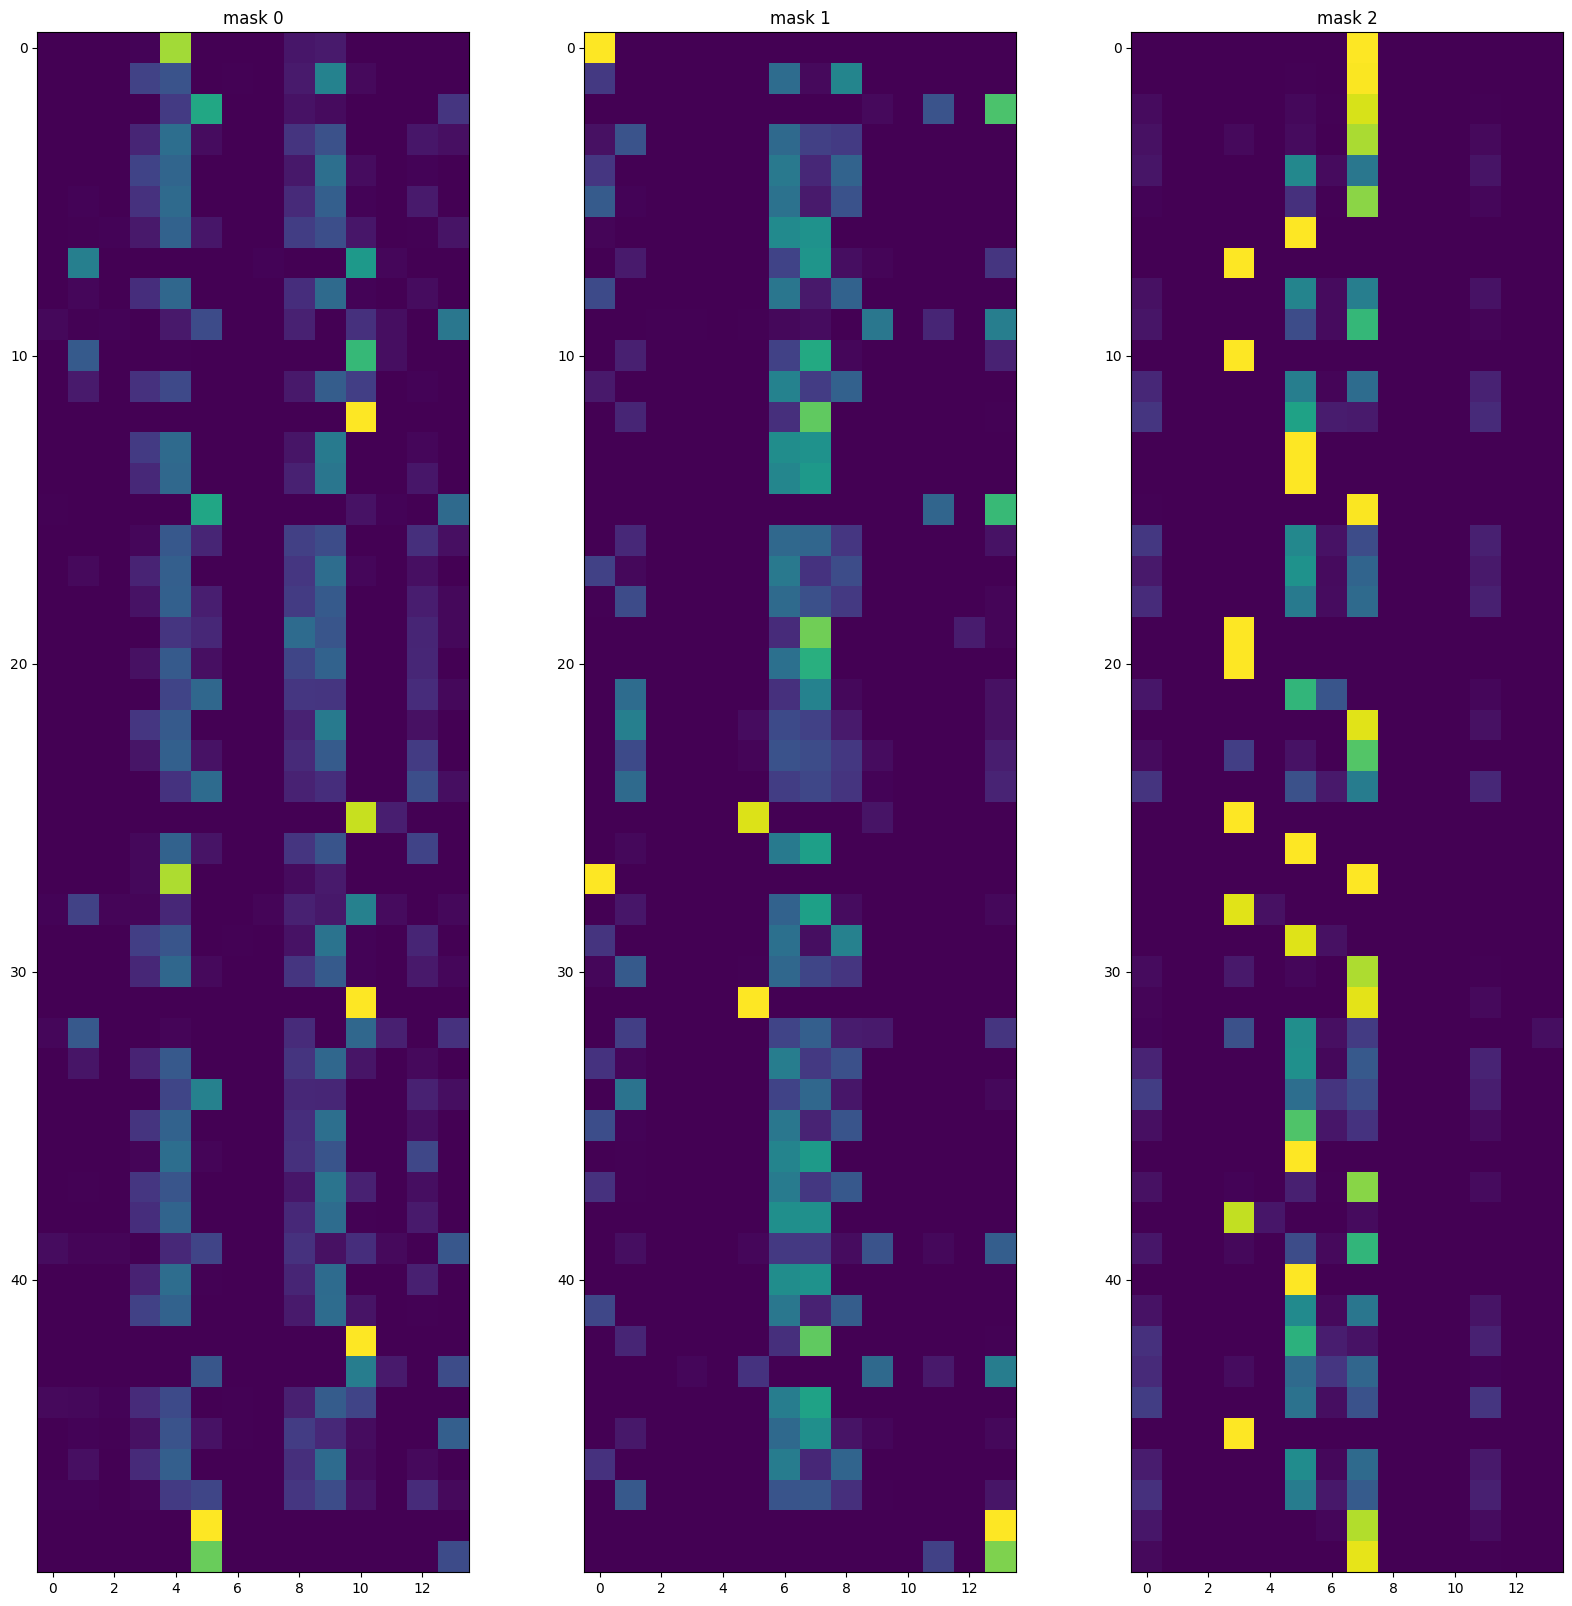

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
